In [ ]:
# !!! only run when using colab !!!
import os
! git clone https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox # downloading the source code
os.chdir("/content/CPlantBox/")
! cmake .
! make
os.chdir("/content/CPlantBox/tutorial/jupyter/workshop_11_2_2022/")

# Workshop 11.2.2022 - (3/3)

## Simulation of xylem water movement 

For calculation of xylem water movement it is necessary to describe the matric potential around the root segments. In the following example we consider a static root system and a static soil. The soil is either coupled per a matric potential around each segment, or the soil matric potentials are given in soil cells, and each segment is to a soil cell where the segment is located. The second approach is necessary if we extend the method to a dynamic soil. 

To compute the xylem flux we use the hybrid analytical approach of Meunier et al. 20XX.

We start with a minimal example with constant conductivities (see *example6b_xylemflux.py*)

Transpiration -1.1850000000000003 cm3/day


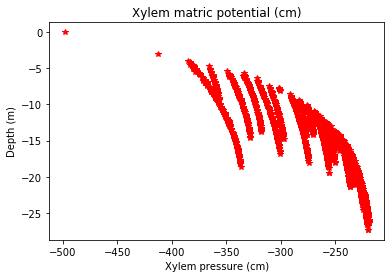

(<vtkmodules.vtkRenderingOpenGL2.vtkOpenGLActor(0x2df5c80) at 0x7f9264504ca0>,
 <vtkmodules.vtkRenderingAnnotation.vtkScalarBarActor(0x1b14480) at 0x7f9236f52e80>)

In [2]:
import sys; sys.path.append("../../.."); sys.path.append("../../../src/python_modules")
from xylem_flux import XylemFluxPython  # Python hybrid solver
import plantbox as pb
import vtk_plot as vp
import numpy as np
import matplotlib.pyplot as plt

""" Parameters """
kz = 4.32e-2  # axial conductivity [cm^3/day]
kr = 1.728e-4  # radial conductivity [1/day]
p_s = -200  # static soil pressure [cm]
p0 = -500  # dircichlet bc at top
simtime = 14  # [day] for task b

""" root system """
rs = pb.MappedRootSystem()
path = "../../../modelparameter/rootsystem/"
name = "Anagallis_femina_Leitner_2010"  # Zea_mays_1_Leitner_2010
rs.readParameters(path + name + ".xml")
rs.initialize()
rs.simulate(simtime, False)

""" root problem """
r = XylemFluxPython(rs)
r.setKr([kr * 0, kr, kr , kr, kr, kr])
r.setKx([kz, kz, kz, kz, kz, kz])
nodes = r.get_nodes()
soil_index = lambda x, y, z: 0 # only one cell, all roots are connected to cell 0
r.rs.setSoilGrid(soil_index)

""" Numerical solution """
rx = r.solve_dirichlet(simtime, p0, p_s, [p_s], True)
trans = -1.185  # cm3
rx = r.solve_neumann(simtime, trans, [p_s], True)
fluxes = r.segFluxes(simtime, rx, -200 * np.ones(rx.shape), False)  # cm3/day
print("Transpiration", r.collar_flux(simtime, rx, [p_s]), "cm3/day")

""" plot results """
plt.plot(rx, nodes[:, 2] , "r*")
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (m)")
plt.title("Xylem matric potential (cm)")
plt.show()

""" Additional vtk plot """
ana = pb.SegmentAnalyser(r.rs)
ana.addData("rx", rx)
ana.addData("fluxes", fluxes)  # cut off for vizualisation
vp.plot_roots(ana, "fluxes", "Xylem matric potential (cm)")  # "rx" fluxes", subType
